In [1]:
import sys
sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')

sys.path.insert(0, '/home/yuncong/project/cython-munkres-wrapper/build/lib.linux-x86_64-2.7')
# import munkres
# reload(munkres)
from munkres import munkres

# https://github.com/jfrelinger/cython-munkres-wrapper,
# 10 times faster than the python implementation http://software.clapper.org/munkres/

# from munkres import Munkres # http://software.clapper.org/munkres/

sys.path.append('/home/yuncong/Brain/pipeline_scripts')
from utilities2014 import *
import os
import time

import random

os.environ['GORDON_DATA_DIR'] = '/home/yuncong/project/DavidData2014tif/'
os.environ['GORDON_REPO_DIR'] = '/home/yuncong/Brain'
os.environ['GORDON_RESULT_DIR'] = '/home/yuncong/project/DavidData2014results/'
os.environ['GORDON_LABELING_DIR'] = '/home/yuncong/project/DavidData2014labelings/'

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filter.rank import gradient

from sklearn.preprocessing import normalize

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def dynamic_programming(Dm, plot_matrix=False):
    
    n_rows, n_cols = Dm.shape
    
    penalty = 0
    
    T = np.zeros((n_rows+1, n_cols+1))
    backtrack = np.zeros((n_rows+1, n_cols+1), np.int)
    
    for j in range(n_cols+1):
        T[0,j] = - penalty * j

    for i in range(n_rows+1):
        T[i,0] = - penalty * i
        
#     print Dm.max(), Dm.min(), Dm.mean()
        
    match = np.zeros((n_rows+1, n_cols+1))
    
    # T stores the average match reward until scanning node i vs j

    for i in range(1, n_rows+1):
        for j in range(1, n_cols+1):
            q = [T[i-1,j-1]+100-Dm[i-1,j-1], T[i,j-1]-penalty, T[i-1,j]-penalty]
            
            backtrack[i,j] = np.argmax(q)
            T[i,j] = np.max(q)


    if plot_matrix:
        
        matshow(T)
        colorbar()
        
        matshow(backtrack)
        colorbar()
        
        TT = np.zeros_like(backtrack, np.int)
        for r,c in steps:
            TT[r,c] = 1
        matshow(TT)
    
    return T, backtrack


def backtrack_mat_to_steps(backtrack, backtrack_start_point):
    steps = []

    r, c = backtrack_start_point
    
    while r > 0 and c > 0:
        a = backtrack[r,c]
        steps.append((r,c))
        if a == 0:
            r = r - 1
            c = c - 1
        elif a == 1:
            c = c - 1
        elif a == 2:
            r = r - 1
            
    return steps


def matching_from_bakctrack(steps):
    
    matches = []
    for i in range(len(steps)-1):
        if steps[i+1][0] != steps[i][0] and steps[i+1][1] != steps[i][1]:
            matches.append((steps[i][0]-1, steps[i][1]-1))
            
    return matches

In [3]:
def chi2(u,v):
    """
    Compute Chi^2 distance between two distributions.
    Empty bins are ignored.
    """
    
    u[u==0] = 1e-6
    v[v==0] = 1e-6
    r = np.sum(((u-v)**2).astype(np.float)/(u+v))
    return r

In [4]:
def boundary_distance(b1, b2, sc1=None, sc2=None, loc_thresh=1500):
    '''
    Compute the distance between two boundaries.
    Each tuple consists of (edgeSet, interior_texture, exterior_textures, points, center)
    
    Parameters
    ----------
    b1 : tuple
    b2 : tuple
    sc1 : #points-by-32 array
        pre-computed shape context descriptor
    sc2 : #points-by-32 array
        pre-computed shape context descriptor
    '''
    
    _, interior_texture1, exterior_textures1, points1, center1 = b1
    _, interior_texture2, exterior_textures2, points2, center2 = b2
    if sc1 is not None:
        assert len(sc1) == points1.shape[0], 'number mismatch %d %d'%(len(sc1), points1.shape[0])
    
    if sc2 is not None:
        assert len(sc2) == points2.shape[0], 'number mismatch %d %d'%(len(sc2), points2.shape[0])

    # compute location difference
    d_loc = np.linalg.norm(center1 - center2)
    D_loc = np.maximum(0, d_loc - 500)
    
#     print 'd_loc', d_loc

    if d_loc > loc_thresh:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    n1 = len(points1)
    n2 = len(points2)
    if max(n1,n2) > min(n1,n2) * 3:
        return np.inf, np.inf, np.inf, np.inf, np.inf
    
    # compute interior texture difference
    D_int = chi2(interior_texture1, interior_texture2)
#     D_ext = hausdorff_histograms(exterior_textures1, exterior_textures2, metric=chi2)

    # compute shape difference, exterior texture difference
    D_shape, matches = shape_context_score(points1, points2, descriptor1=sc1, descriptor2=sc2)
#         D_ext = np.mean([chi2(exterior_textures1[i], exterior_textures2[j]) for i, j in matches])

    bg_match = 0

    if len(matches) == 0:
        D_ext = np.inf
    else:
        ddd = []
        for i, j in matches:
            # -1 vs -1
            if np.isnan(exterior_textures1[i]).all() and np.isnan(exterior_textures2[j]).all():
                s = 0
                bg_match += 1
                ddd.append(s)
            # non -1 vs non -1
            elif not np.isnan(exterior_textures1[i]).all() and not np.isnan(exterior_textures2[j]).all():
                s = chi2(exterior_textures1[i], exterior_textures2[j])
                if OUTPUT:
                    print 'exterior', i,j,s
                ddd.append(s)
            # -1 vs non -1
            else:
                ddd.append(2.)

        if len(ddd) == 0:
            D_ext = np.inf
        elif len(ddd) == bg_match:
            D_ext = 2.
        else:
            D_ext = np.mean(ddd)
    
    D_shape = D_shape * .004

    # weighted average of four terms
    d = D_int + D_ext + D_shape + 0 * D_loc
    
    return d, D_int, D_ext, D_shape, D_loc


In [5]:
def sort_counterclockwise(pts, return_order=False):
    '''
    sort points from -pi to pi with respect to center
    '''
    center = np.mean(pts, axis=0)
    vecs = pts - center
    angles = np.arctan2(vecs[:,1], vecs[:,0])
    order = np.argsort(angles)
    if return_order:
        return pts[order], order
    else:
        return pts[order]

def rigid_transform_from_pairs(X,Y):
    Xcentroid = X.mean(axis=0)
    Ycentroid = Y.mean(axis=0)
    
    Xcentered = X - Xcentroid
    Ycentered = Y - Ycentroid
    
    U, S, V = np.linalg.svd(np.dot(Xcentered.T, Ycentered))
    M = [[1, 0], [0, np.linalg.det(np.dot(V, U.T))]]
    R = np.dot(V, np.dot(M, U.T))
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid.T - np.dot(R, Xcentroid.T)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
    pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans


In [6]:
def plot_two_pointsets(pts1, pts2, center1=True, center2=True, text=True, 
                       matchings=None,
                       show_sc1=None, show_sc2=None, r_array=None, n_angles=None):
    '''
    show_sc1 is the point index on which to draw shape context polar histogram boundaries
    '''

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
#     ax.scatter(pts1[:,0], pts1[:,1], c='r', label='PointSet 1', s=40)
#     ax.scatter(pts2[:,0], pts2[:,1], c='g', label='PointSet 2', s=40)
    ax.scatter(pts1[:,0], pts1[:,1], c='r', label='PointSet 1', s=5)
    ax.scatter(pts2[:,0], pts2[:,1], c='g', label='PointSet 2', s=5)


    if center1:
        center1 = pts1.mean(axis=0)
        ax.scatter(center1[0], center1[1], c='b')

    if center2:
        center2 = pts2.mean(axis=0)
        ax.scatter(center2[0], center2[1], c='b')

    if text:
        for i, (y,x) in enumerate(pts1):
            ax.text(y, x, str(i), color='r')

        for i, (y,x) in enumerate(pts2):
            ax.text(y, x, str(i), color='g')
    
    if matchings is not None:
        for i,j in matchings:
            ln = plt.Line2D(np.r_[pts1[i,0], pts2[j,0]], np.r_[pts1[i,1], pts2[j,1]], c='k')
            fig.gca().add_artist(ln)
    
    if show_sc1 is not None:
        assert r_array is not None and n_angles is not None
        dists_max1 = pdist(pts1).max() 
        scales1 = dists_max1 * r_array
        
        for s in scales1:
            circle = plt.Circle(pts1[show_sc1], s, color='k', fill=False)
            fig.gca().add_artist(circle)

        for a in np.linspace(0, 2*np.pi, n_angles+1):
            ln = plt.Line2D(np.r_[pts1[show_sc1,0], pts1[show_sc1,0]+scales1[-1]*np.cos(a)], 
                            np.r_[pts1[show_sc1,1], pts1[show_sc1,1]+scales1[-1]*np.sin(a)], c='k')
            fig.gca().add_artist(ln)
            
    if show_sc2 is not None:
        assert r_array is not None and n_angles is not None
        dists_max2 = pdist(pts2).max()
        scales2 = dists_max2 * r_array

        for s in scales2:
            circle = plt.Circle(pts2[show_sc2], s, color='k', fill=False)
            fig.gca().add_artist(circle)
            
        for a in np.linspace(0, 2*np.pi, n_angles+1):
            ln = plt.Line2D(np.r_[pts2[show_sc2,0], pts2[show_sc2,0]+scales2[-1]*np.cos(a)], 
                            np.r_[pts2[show_sc2,1], pts2[show_sc2,1]+scales2[-1]*np.sin(a)], c='k')
            fig.gca().add_artist(ln)

            
#     ax.legend()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

In [7]:
def stable(rankings, A, B):
    partners = dict((a, (rankings[(a, 1)], 1)) for a in A)
    is_stable = False # whether the current pairing (given by `partners`) is stable
    while is_stable == False:
        is_stable = True
        for b in B:
            is_paired = False # whether b has a pair which b ranks <= to n
            for n in range(1, len(B) + 1):
                a = rankings[(b, n)]
                a_partner, a_n = partners[a]
                if a_partner == b:
                    if is_paired:
                        is_stable = False
                        partners[a] = (rankings[(a, a_n + 1)], a_n + 1)
                    else:
                        is_paired = True
    return sorted((a, b) for (a, (b, n)) in partners.items())


def stable_marriage_matchings(D_boundaries):

    A = ['A'+str(i) for i in range(n_boundaries1)]
    B = ['B'+str(i) for i in range(n_boundaries2)]

    ao = np.zeros(D_boundaries)
    for q in range(n_boundaries1):
        ao[q, np.argsort(D_boundaries[q,:])] = np.arange(n_boundaries2)

    bo = np.zeros_like(D_boundaries.T)
    for q in range(n_boundaries2):
        bo[q, np.argsort(D_boundaries[:,q])] = np.arange(n_boundaries1)

    rankings1 = zip(A, ao+1)
    rankings2 = zip(B, bo+1)
    rank = dict(rankings1+rankings2)

    Arankings = dict(((a, rank[a][b_]), B[b_]) for (a, b_) in product(A, range(n_boundaries2)))
    Brankings = dict(((b, rank[b][a_]), A[a_]) for (b, a_) in product(B, range(n_boundaries1)))
    rankings = Arankings
    rankings.update(Brankings)

    m = stable(rankings, A, B)
    m = [(int(i[1:]), int(j[1:])) for i, j in m]
    m = sorted([(D_boundaries[i,j], i,j) for i,j in m if D_boundaries[i,j]<np.inf])

#     for s, i,j in m:
#         print s, i, j
    
    return m

def greedy_matching(D_boundaries, verified_matchings=[], excluded_matchings=[]):
    
    thresh_percentage = .2
    th = np.sort(D_boundaries[D_boundaries < np.inf].flat)[int(len(D_boundaries[D_boundaries < np.inf].flat)*thresh_percentage)]
    print 'thresh', th
    
    matchings = verified_matchings[:]
    rs, cs = np.unravel_index(np.argsort(D_boundaries.flat), D_boundaries.shape)
    for r, c in zip(rs, cs):
        if (r,c) in excluded_matchings:
            continue
        if D_boundaries[r,c] > th:
            break
        if r not in [i for i,j in matchings] and c not in [j for i,j in matchings]:
            matchings.append((r,c))
            
    return matchings

In [8]:
def centering(ps):
    return ps - ps.mean(axis=0)

def hausdorff(ps1, ps2, center=False):
    if center:
        ps1 = centering(ps1)
        ps2 = centering(ps2)
    D = cdist(ps1, ps2)
    return max(np.max(D.min(axis=0)), np.max(D.min(axis=1)))

def hausdorff_histograms(h1s, h2s, metric):
    Ds = cdist(h1s, h2s, metric)
    return max(np.nanmax(np.nanmin(Ds, axis=1)), np.nanmax(np.nanmin(Ds, axis=0)))

# def allunique(x):
#     return len(x) == len(set(x))

def ransac_compute_rigid_transform(Dm, pts1, pts2, confidence_thresh=.01, ransac_iters=20, sample_size=5,
                                  matching_iter=10):

    high_confidence_thresh = np.sort(Dm.flat)[int(confidence_thresh * len(Dm.flat))]
#     print 'high_confidence_thresh', high_confidence_thresh
        
    high_confidence_pairs = []
    rs, cs = np.where(Dm < high_confidence_thresh)
    for r,c in zip(rs,cs):
        high_confidence_pairs.append((r, c))
    if OUTPUT:
        print 'high_confidence_pairs', high_confidence_pairs
    
#     q = time.time()
    from itertools import combinations
    possible_samples = list(combinations(high_confidence_pairs, sample_size))
    random.shuffle(possible_samples)
#     print 'comb', time.time() - q        
    
#     n_possible_samples = len([t for t in combinations(high_confidence_pairs, sample_size) 
#                         if allunique([tt[0] for tt in t]) and allunique([tt[1] for tt in t])])
#     print 'n_possible_samples', n_possible_samples
#     random.shuffle(possible_samples)
    
    
    p1s = sorted(list(set([i for i,j in high_confidence_pairs])))
    p2s = sorted(list(set([j for i,j in high_confidence_pairs])))
    n1 = len(p1s)
    n2 = len(p2s)
    
    offsets = []
    scores = []
    matches_list = []
    samples_list = []
    
    sample_counter = 0
    for ri in range(min(ransac_iters, len(possible_samples))):
        
        samples = []
        rs = set([])
        cs = set([])
        
        while True:
            s = possible_samples[sample_counter]
            sample_counter += 1
            w1, w2 = zip(*s)
            if len(set(w1)) == len(w1) and len(set(w2)) == len(w2):
                samples = s
                break

#         samples = np.array(possible_samples[ri])

        if OUTPUT:
            print '\nsamples', ri, samples
        
        X = pts1[[s[0] for s in samples]]
        Y = pts2[[s[1] for s in samples]]
                
        # generate transform hypothesis
        T, angle = rigid_transform_from_pairs(X, Y)
        if np.abs(angle) > np.pi/2:
            if OUTPUT:
                print 'angle too wide', np.rad2deg(angle)
            continue
        
        # apply transform hypothesis
        pts1_trans = rigid_transform_to(pts1, T)
        
        # iterative closest point association
        matches = None
        matches_prev = None
        
        for mi in range(matching_iter):
  
            # given transform, find matching
                    
            Dh = cdist(pts1_trans, pts2, metric='euclidean')
            Dargmin1 = Dh.argsort(axis=1)
            Dargmin0 = Dh.argsort(axis=0)
    
    
            relaxed_confidence_thresh = 0.1
            relaxed_high_confidence_thresh = np.sort(Dm.flat)[int(relaxed_confidence_thresh * len(Dm.flat))]

            relaxed_high_confidence_pairs = []
            rs, cs = np.where(Dm < relaxed_high_confidence_thresh)
            for r,c in zip(rs,cs):
                relaxed_high_confidence_pairs.append((r, c))

            p1s = sorted(list(set([i for i,j in relaxed_high_confidence_pairs])))
            p2s = sorted(list(set([j for i,j in relaxed_high_confidence_pairs])))
            n1 = len(p1s)
            n2 = len(p2s)
                
            D_hc_pairs = 9999 * np.ones((n1, n2))
            for i,j in relaxed_high_confidence_pairs:
                if j in Dargmin1[i,:10] and i in Dargmin0[:10,j]:
                    ii = p1s.index(i)
                    jj = p2s.index(j)
                    D_hc_pairs[ii, jj] = Dh[i,j]

            if matches is not None:
                matches_prev = matches
            
#             b = time.time()
            matches_hc_pairs = np.array(zip(*np.nonzero(munkres(D_hc_pairs))))
#             print 'munkres', time.time() - b, mi
            
            q1, q2 = np.where(D_hc_pairs < 9999)
            w = zip(*[np.array(p1s)[q1], np.array(p2s)[q2]])
#                 print [(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs]
            
            matches = np.array([(p1s[ii], p2s[jj]) for (ii,jj) in matches_hc_pairs
                                if D_hc_pairs[ii, jj] != 9999])
            # some 9999 edges will be included, the "if" above removes them

            if OUTPUT:
#                 print 'considered pairs', w
#                 print 'matches', [(i,j) for i,j in matches
                print 'matches', len(matches), '/', 'considered pairs', len(w), '/', 'all hc pairs', len(high_confidence_pairs), '/ relax', len(relaxed_high_confidence_pairs)

            if len(matches) < 3:
                s = np.inf
                break
            else:                
                xs1 = pts1_trans[matches[:,0], 0]
                x_coverage1 = float(xs1.max() - xs1.min()) / (pts1_trans[:,0].max() - pts1_trans[:,0].min())
                ys1 = pts1_trans[matches[:,0], 1]
                y_coverage1 = float(ys1.max() - ys1.min()) / (pts1_trans[:,1].max() - pts1_trans[:,1].min())
                
                xs2 = pts2[matches[:,1], 0]
                x_coverage2 = float(xs2.max() - xs2.min())/ (pts2[:,0].max() - pts2[:,0].min())
                ys2 = pts2[matches[:,1], 1]
                y_coverage2 = float(ys2.max() - ys2.min())/ (pts2[:,1].max() - pts2[:,1].min())
                
                coverage = .5 * x_coverage1 * y_coverage1 + .5 * x_coverage2 * y_coverage2
                
                s = Dh[matches[:,0], matches[:,1]].mean() / coverage
#             s = .5 * Dm[Dh.argmin(axis=0), np.arange(len(pts2))].mean() + .5 * Dm[np.arange(len(pts1)), Dh.argmin(axis=1)].mean()            
#             s = np.mean([np.mean(Dh.min(axis=0)), np.mean(Dh.min(axis=1))])
                    
            X = pts1[matches[:,0]]
            Y = pts2[matches[:,1]]

            T, angle = rigid_transform_from_pairs(X, Y)
            if np.abs(angle) > np.pi/2:
                break

            pts1_trans = rigid_transform_to(pts1, T)

            if matches_prev is not None and all([(i,j) in matches_prev for i,j in matches]):
                break
            
                
        samples_list.append(samples)
        offsets.append(T)
        matches_list.append(matches)
        scores.append(s)
    
#         print matches
#         print s
#         plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), 
#                    center1=False, center2=False,
#                    text=True, matchings=matches)
            
    if len(scores) > 0:
        best_i = np.argmin(scores)

        best_score = scores[best_i]
        best_T = offsets[best_i]
        best_sample = samples_list[best_i]
        best_matches = matches_list[best_i]    
    
        return best_T, best_matches, best_sample, best_score
    else:
        return None, [], None, np.inf


def shape_context_score(pts1, pts2, descriptor1=None, descriptor2=None):

    if descriptor1 is None:
        descriptor1 = compute_shape_context_descriptors(pts1, dist_limit=.8)
    
    if descriptor2 is None:
        descriptor2 = compute_shape_context_descriptors(pts2, dist_limit=.8)
        
    descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')
        
#     b = time.time()

    T, best_match, best_sample, best_score = ransac_compute_rigid_transform(descriptor_dists, pts1, pts2, 
                                                                            ransac_iters=50, confidence_thresh=0.03, 
                                                                            sample_size=3, matching_iter=10)
#     print 'ransac_compute_rigid_transform', time.time() - b

    
    if T is None and len(best_match)==0:
        return np.inf, []
    
    if OUTPUT:
        print 'best_match', best_match
        print 'best_sample', best_sample
        print 'best_score', best_score

    return best_score, best_match
    

def euclidean_dists_angles(points):
    """Returns symmetric pairwise ``dists`` and ``angles`` arrays."""
    
    n = len(points)
    dists = squareform(pdist(points, 'euclidean'))

    xd = -np.subtract.outer(points[:,0], points[:,0])
    yd = -np.subtract.outer(points[:,1], points[:,1])
    angles = np.arctan2(yd,xd)

    closest_neighbor = dists.argsort(axis=1)[:,1]
    tangent_vectors = points[closest_neighbor] - points
    tangent_angles = np.arctan2(tangent_vectors[:,1], tangent_vectors[:,0])

    angles = angles - tangent_angles[:, np.newaxis]
    angles = angles%(2*np.pi)
    angles[angles > np.pi] = angles[angles > np.pi] - 2*np.pi

    return dists, angles

def compute_r_theta_bins(n_radial_bins=5, n_polar_bins=12, dist_limit=1.):
    """
    Generate radius-theta bins for the shape context histogram.
    
    Args:
        n_radial_bins (int): number of radial bins
        n_polar_bins (int): number of polar bins
        dist_limit (float): between 0 and 1

    Returns:
        (float array, float array): (r_array, theta_array)

    """
        
    base = 10.    
    r_array = dist_limit * (np.logspace(0, 1, n_radial_bins + 1, base=10) - 1)[1:] / (base-1)
    theta_array = np.linspace(-np.pi, np.pi, n_polar_bins + 1)[1:]
    
    return r_array, theta_array

def compute_shape_context_descriptors(pts, n_radial_bins=5, n_polar_bins=12, 
                                      dist_limit=1., density=True):

    dists, angles = euclidean_dists_angles(pts)
    n_points = dists.shape[0]
    
    r_array, theta_array = compute_r_theta_bins(n_radial_bins, n_polar_bins, dist_limit)
    
    descriptors_mat = np.zeros((n_points, n_radial_bins, n_polar_bins), dtype=np.int)

    dists = dists / dists.max()

    for i in range(n_points):
        for j in range(i + 1, n_points):
            
            if dists[i, j] >= r_array[-1]:
                continue

            r_idx = np.searchsorted(r_array, dists[i, j])
            theta_idx = np.searchsorted(theta_array, angles[i, j])

            descriptors_mat[i, r_idx, theta_idx] += 1

            theta_idx = np.searchsorted(theta_array, angles[j, i])
            descriptors_mat[j, r_idx, theta_idx] += 1

    descriptors = descriptors_mat.reshape(descriptors_mat.shape[0], -1)

    if density:
        descriptors = normalize(descriptors.astype(np.float), axis=1)
    
    return descriptors

In [9]:
sec1 = 20
sec2 = 22

dm1 = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec1)
dm2 = DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=sec2)

boundaries1 = dm1.load_pipeline_result('boundaryModels', 'pkl')
boundaries2 = dm2.load_pipeline_result('boundaryModels', 'pkl')

n_boundaries1 = len(boundaries1)
n_boundaries2 = len(boundaries2)
print n_boundaries1, n_boundaries2

sc1 = dm1.load_pipeline_result('shapeContext', 'pkl')
sc2 = dm2.load_pipeline_result('shapeContext', 'pkl')

lm_types1 = dm1.load_pipeline_result('nonoverlapLmTypes', 'npy')
lm_types2 = dm2.load_pipeline_result('nonoverlapLmTypes', 'npy')

boundary_ind1 = 26
boundary_ind2 = 25

32 32


In [10]:
OUTPUT= False

b = time.time()
print boundary_distance(boundaries1[boundary_ind1], boundaries2[boundary_ind2], 
                        sc1=sc1[boundary_ind1], sc2=sc2[boundary_ind2])
print time.time() - b

(1.019530861135562, 0.0081965737317557501, 0.54089720518656537, 0.47043708221724079, 314.06580502405166)
0.42450094223


matching [[ 0 11]
 [ 1 15]
 [ 5  1]
 [ 6  8]
 [ 8 30]
 [ 9 16]
 [10 24]
 [11 49]
 [12 22]
 [13 20]
 [15 29]
 [16 25]
 [17 55]
 [18 53]
 [19 34]
 [20  3]
 [22 32]
 [28 39]
 [30  7]
 [34 17]
 [36 28]
 [37 38]
 [40 31]
 [41 50]
 [42  9]
 [45 33]]
sample ((17, 55), (28, 16), (36, 28))
score 116.008088426


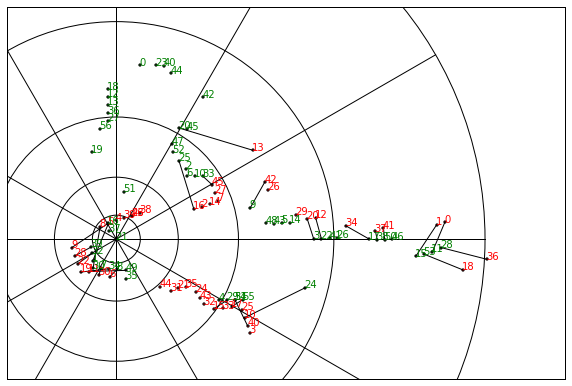

In [12]:
OUTPUT= False

pts1 = boundaries1[boundary_ind1][3].copy()
pts2 = boundaries2[boundary_ind2][3].copy()

n_radial_bins = 5
dist_limit = 1.

descriptor1 = compute_shape_context_descriptors(pts1, n_radial_bins, dist_limit=dist_limit)
descriptor2 = compute_shape_context_descriptors(pts2, n_radial_bins, dist_limit=dist_limit)
descriptor_dists = cdist(descriptor1, descriptor2, metric='euclidean')

r_array, theta_array = compute_r_theta_bins(n_radial_bins=n_radial_bins, n_polar_bins=12, dist_limit=dist_limit)


T, matching, sample, score = ransac_compute_rigid_transform( descriptor_dists, pts1, pts2, 
                                                            ransac_iters=100, confidence_thresh=0.03, sample_size=3,
                                                            matching_iter=10)
print 'matching', matching
print 'sample', sample
print 'score', score

pts1_trans = rigid_transform_to(pts1, T)

# plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), center1=False, center2=False,
#                   show_sc1=3, r_array=r_array, n_angles=12, text=False)
# plt.bar(range(len(descriptor1[3])), descriptor1[3]);
# plt.xlabel('bin number');

# plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), center1=False, center2=False,
#                   show_sc1=61, r_array=r_array, n_angles=12, text=False)
# plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), center1=False, center2=False,
#                   text=False)

# plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), center1=False, center2=False,
#                   matchings=matching, text=False)

plot_two_pointsets(pts1_trans[:,::-1]*np.array([1,-1]), pts2[:,::-1]*np.array([1,-1]), center1=False, center2=False,
                  show_sc2=21, r_array=r_array, n_angles=12, 
                   text=True, matchings=matching)

# plot_two_pointsets(pts1_trans, pts2, center1=False, center2=False,
#                   show_sc2=21, r_array=r_array, n_angles=12, 
#                    text=True, matchings=matching)

# plt.bar(range(len(descriptor2[21])), descriptor2[21]);
# plt.xlabel('bin number');


In [ ]:
OUTPUT=False

# sc1 = dm1.load_pipeline_result('shapeContext', 'pkl')
# sc2 = dm2.load_pipeline_result('shapeContext', 'pkl')

Ds = Parallel(n_jobs=16)(delayed(boundary_distance)(boundaries1[i], boundaries2[j]) 
                         for i, j in product(range(n_boundaries1), range(n_boundaries2)))
D_boundaries, D_int, D_ext, D_shape, D_loc = zip(*Ds)

D_boundaries = np.reshape(D_boundaries, (n_boundaries1, n_boundaries2))
D1 = np.reshape(D_int, (n_boundaries1, n_boundaries2))
D2 = np.reshape(D_ext, (n_boundaries1, n_boundaries2))
D3 = np.reshape(D_shape, (n_boundaries1, n_boundaries2))
D4 = np.reshape(D_loc, (n_boundaries1, n_boundaries2))

In [55]:
print np.mean(D1[D1!=np.inf])
print np.mean(D2[D2!=np.inf])
print np.mean(D3[D3!=np.inf])

0.634368827043
0.782272640199
0.381697074605


In [76]:
print D_boundaries.argsort(axis=1)[15,:3]
print D1.argsort(axis=1)[15,:3]
print D2.argsort(axis=1)[15,:3]
print D3.argsort(axis=1)[15,:3]

[ 5  7 20]
[ 5 20  7]
[10  1 21]
[ 1 21  7]


In [35]:
# D_boundaries = dm1.load_pipeline_result('DBoundaries%dWith%d'%(sec1, sec2), 'npy')
# D1 = dm1.load_pipeline_result('D1s%dWith%d'%(sec1, sec2), 'npy')
# D2 = dm1.load_pipeline_result('D2s%dWith%d'%(sec1, sec2), 'npy')
# D3 = dm1.load_pipeline_result('D3s%dWith%d'%(sec1, sec2), 'npy')
# D4 = dm1.load_pipeline_result('D4s%dWith%d'%(sec1, sec2), 'npy')

In [74]:
# 17 vs 19
true_matchings = []
ok_matchings = []

excluded_matchings = []
verified_matchings = [(6,5)]

In [75]:
matchings = greedy_matching(D_boundaries, verified_matchings, excluded_matchings)

corr = 0
parcorr = 0
err = 0
crosstype = 0

for i,j in matchings:
    print D_boundaries[i,j], i, j
    if (i,j) in true_matchings:
        corr += 1.
        if int(lm_types1[i]) != int(lm_types2[j]):
            crosstype += 1.
    elif (i,j) in ok_matchings:
        parcorr += 1.
        if int(lm_types1[i]) != int(lm_types2[j]):
            crosstype += 1.
    else:
        err += 1.
        
n = len(matchings)
tps = set(true_matchings) | set(ok_matchings)
recall = (corr+parcorr)/len(tps)
precision = (corr+parcorr)/n
beta = 5 # means how many times recall is important than precision
F = (1+beta**2) * (recall*precision) / (beta**2*precision + recall)
print '\nrecall = %.2f, precision = %.2f, F = %.2f' % (recall, precision, F)

missed = tps - set(matchings)
print 'missed', missed, 'among them, the smallest distance is', np.min([D_boundaries[i,j] for i,j in missed])
wrong = set(matchings) - tps
print 'wrong', wrong
print 'Of all correct matchings, %.1f%% is between different types' % (crosstype/n*100)

thresh 1.12694396256
0.658613985689 6 5
0.473149855569 24 25
0.598033844784 4 7
0.618851374817 0 1
0.722341501482 15 20
0.747507257546 28 19
0.762390563575 22 26
0.764653470039 7 4
0.81026332138 20 15
0.825577338145 5 10
0.845226201147 9 16
0.860331442378 27 3
0.866090821218 25 2
0.876689416395 26 28
0.880063365211 16 9
0.915097102686 10 13
0.916641043565 23 24
0.968396780035 19 17
1.03848094598 12 12
1.07139596363 18 14


ZeroDivisionError: integer division or modulo by zero

In [ ]:
# one-dimensional embedding

from networkx import from_dict_of_lists, draw_networkx, from_dict_of_dicts, dfs_edges, dfs_tree, all_pairs_dijkstra_path_length

D = pdist(boundaries1[20][3])
D = squareform(D)
D_sorted = np.sort(D, axis=1)[:,1:4]
nearest_neighbors = D.argsort(axis=1)[:,1:4]

nearest_neighbors_dict = dict([(i, dict([(j, {'weight':D_sorted[i, k]}) for k, j in enumerate(a)])) for i, a in enumerate(nearest_neighbors)])
# print nearest_neighbors_dict[0]

G = from_dict_of_dicts(nearest_neighbors_dict)
draw_networkx(G, with_labels=False, node_size=10)

# print dfs_edges(G)
draw_networkx(dfs_tree(G, 1), with_labels=False, node_size=10)

geodesic_dists_dict = all_pairs_dijkstra_path_length(G)
geodesic_dists = np.array([[d for j, d in a.iteritems()] for i, a in geodesic_dists_dict.iteritems()])
geodesic_dists = np.minimum(geodesic_dists, geodesic_dists.T)